# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откройте и изучите файл

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.dummy import DummyClassifier

In [2]:
#читаем данные из файла
df = pd.read_csv('/datasets/users_behavior.csv')
#выведем на экран 10 первых строк
df.head(10)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


In [3]:
#изучим структуру данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


В таблице 3214 объекта. Пропусков нет.

In [4]:
#заменим тип float64 в столбцах calls и messages на тип int, так как данные целочисленные
df['calls'] = df['calls'].astype('int')
df['messages'] = df['messages'].astype('int')

In [5]:
#проверим
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   int64  
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   int64  
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 125.7 KB


In [6]:
#посмотрим какое количество клиентов используют каждый тариф
df['is_ultra'].value_counts(normalize=True)

0    0.693528
1    0.306472
Name: is_ultra, dtype: float64

**Вывод:**
    
    - В таблице 3214 объекта 
    - Пропусков нет
    - 31% клиентов используют тариф "Ультра"
    - 69% клиентов используют тариф "Смарт"

## Разбейте данные на выборки

Исходные данные:
    
    - Признаки: 'calls', 'minutes', 'messages', 'mb_used'
    - Целевой признак: 'is_ultra'

In [7]:
features = df.drop('is_ultra', axis=1)
target = df['is_ultra']

- Разделим данные на обучающую, валидационную и тестовую выборки в пропорции 3:1:1 соответственно (60% на обучающию и по 20% данных на валидационную и тестовую выборки)

In [8]:
#Разделим features
features_train, features_valid = train_test_split(
    features, test_size=0.4, random_state=12345) 


features_valid, features_test = train_test_split(
    features_valid, test_size=0.5, random_state=12345) 

In [9]:
print('Размер обучающей выборки:', features_train.shape, '-', round(len(features_train) / len(df)*100), '%')
print('Размер валидационной выборки:', features_valid.shape, '-', round(len(features_valid) / len(df)*100), '%')
print('Размер тестовой выборки:', features_test.shape, '-', round(len(features_test) / len(df)*100), '%')

Размер обучающей выборки: (1928, 4) - 60 %
Размер валидационной выборки: (643, 4) - 20 %
Размер тестовой выборки: (643, 4) - 20 %


In [10]:
#Разделим target
target_train, target_valid = train_test_split(
    target, test_size=0.4, random_state=12345) 

target_valid, target_test = train_test_split(
    target_valid, test_size=0.5, random_state=12345)

In [11]:
print('Размер обучающей выборки:', target_train.shape, '-', round(len(features_train) / len(df)*100), '%')
print('Размер валидационной выборки:', target_valid.shape, '-', round(len(features_valid) / len(df)*100), '%')
print('Размер тестовой выборки:', target_test.shape, '-', round(len(features_test) / len(df)*100), '%')

Размер обучающей выборки: (1928,) - 60 %
Размер валидационной выборки: (643,) - 20 %
Размер тестовой выборки: (643,) - 20 %


## Исследуйте модели

### Дерево решений

In [13]:
#Проверим различного значения глубины деревьев в диапазоне от 1 до 10. 

best_model_dt = None
best_result = 0
best_depth = 0

for depth in range(1, 11):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    result = accuracy_score(target_valid, predictions)
    if result > best_result:
        best_model_dt = model
        best_result = result
        best_depth = depth
print('Наилучшее значение показала модель с "глубиной деревьев" =', best_depth, ', accuracy =', best_result)

Наилучшее значение показала модель с "глубиной деревьев" = 3 , accuracy = 0.7853810264385692


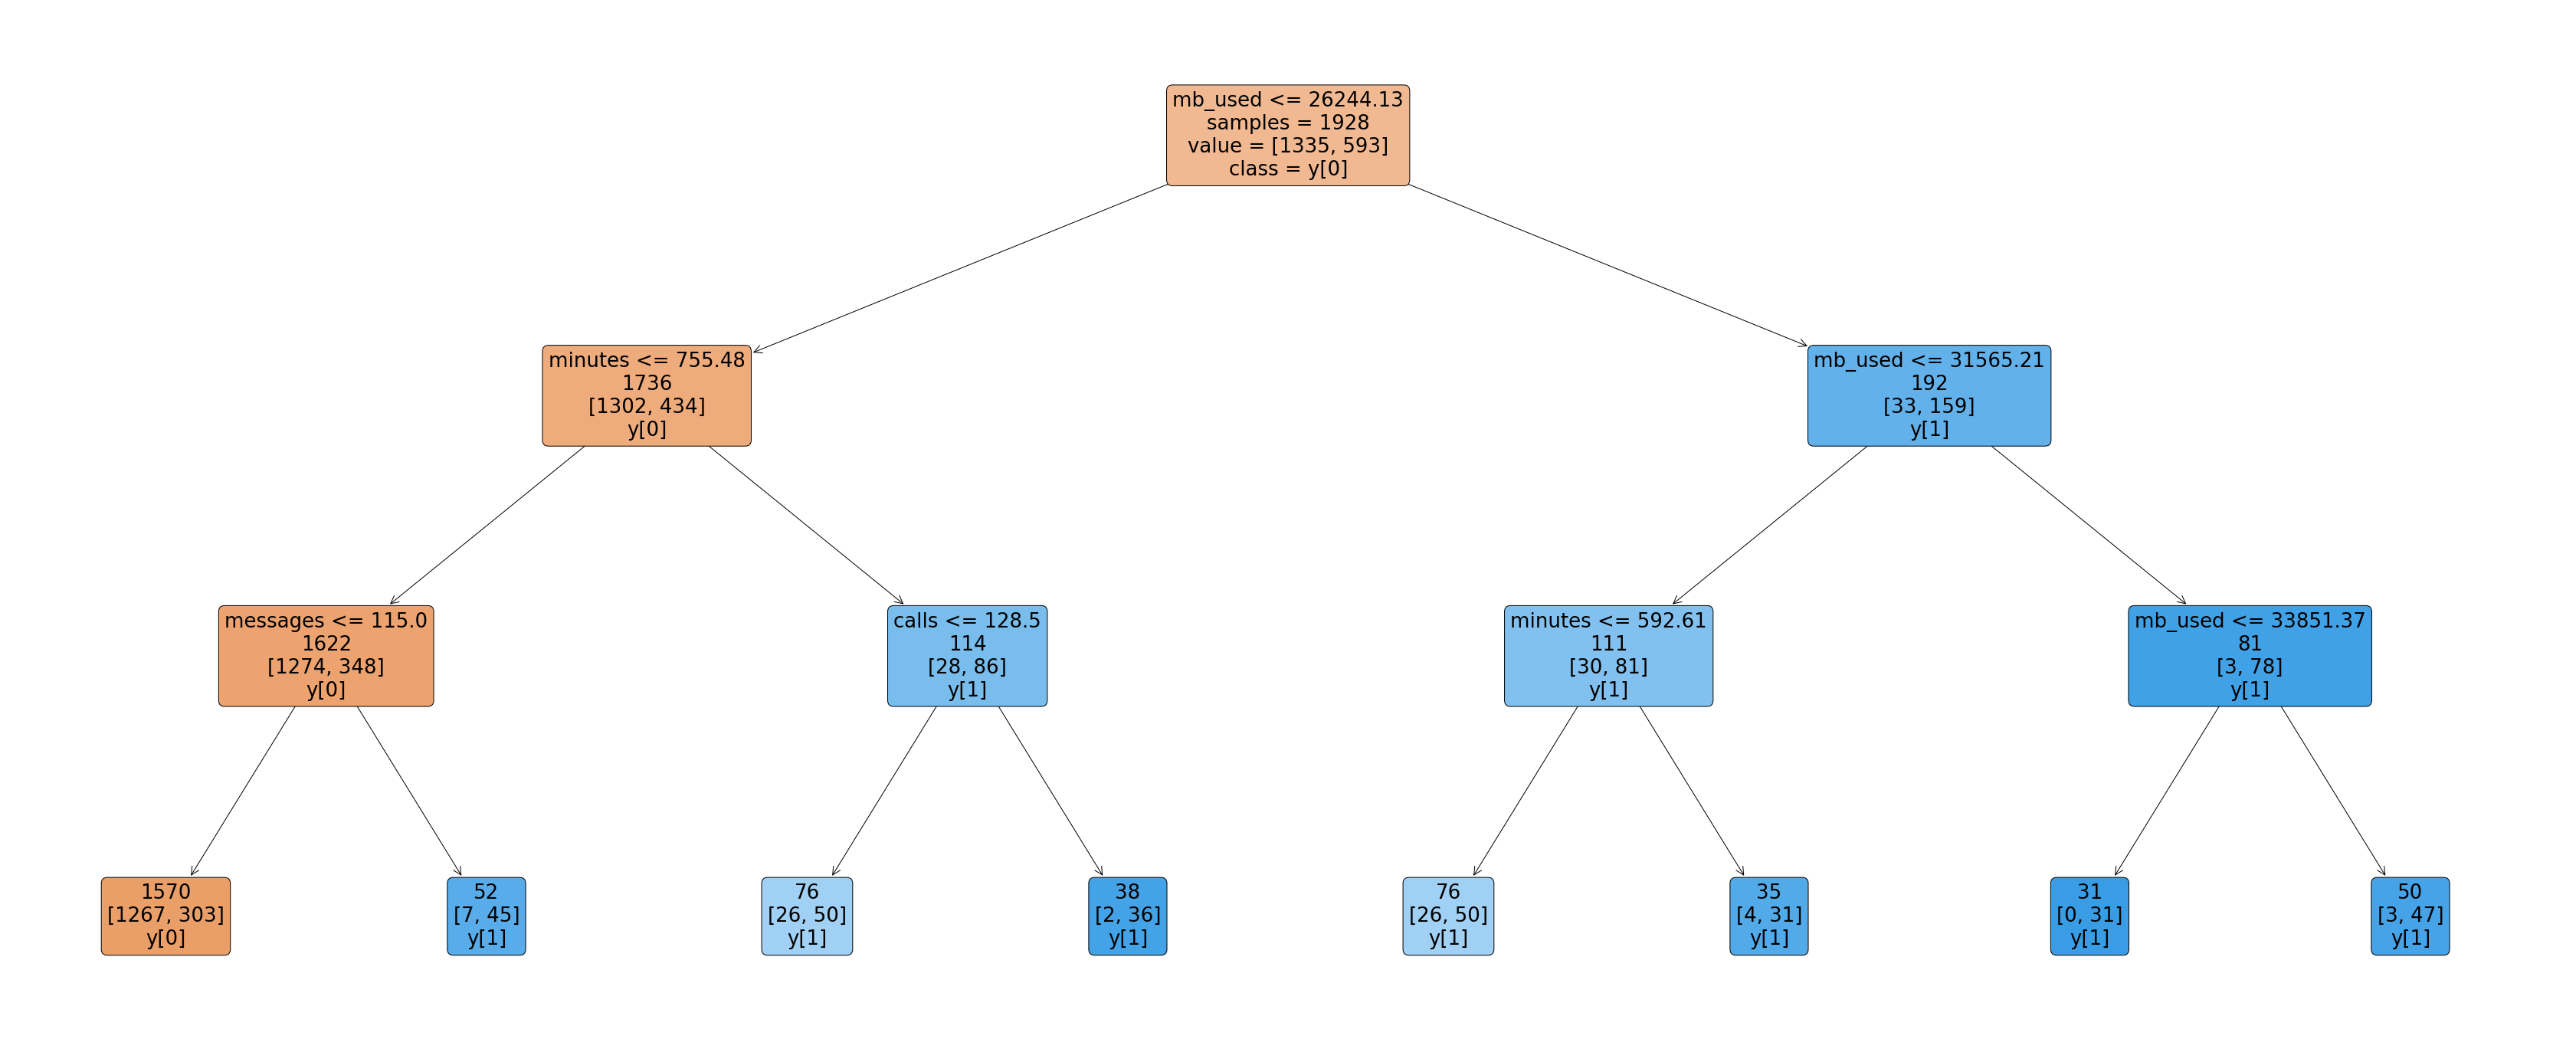

In [14]:
#Построим график с "глубиной деревьев" = 3
plt.figure(figsize=(60,25))
fig = plot_tree(best_model_dt, 
                feature_names=features_train.columns, 
                precision = 2,
                filled = True, 
                rounded = True,
                class_names = True,
                fontsize = 26, 
                label = 'root', 
                impurity=False)

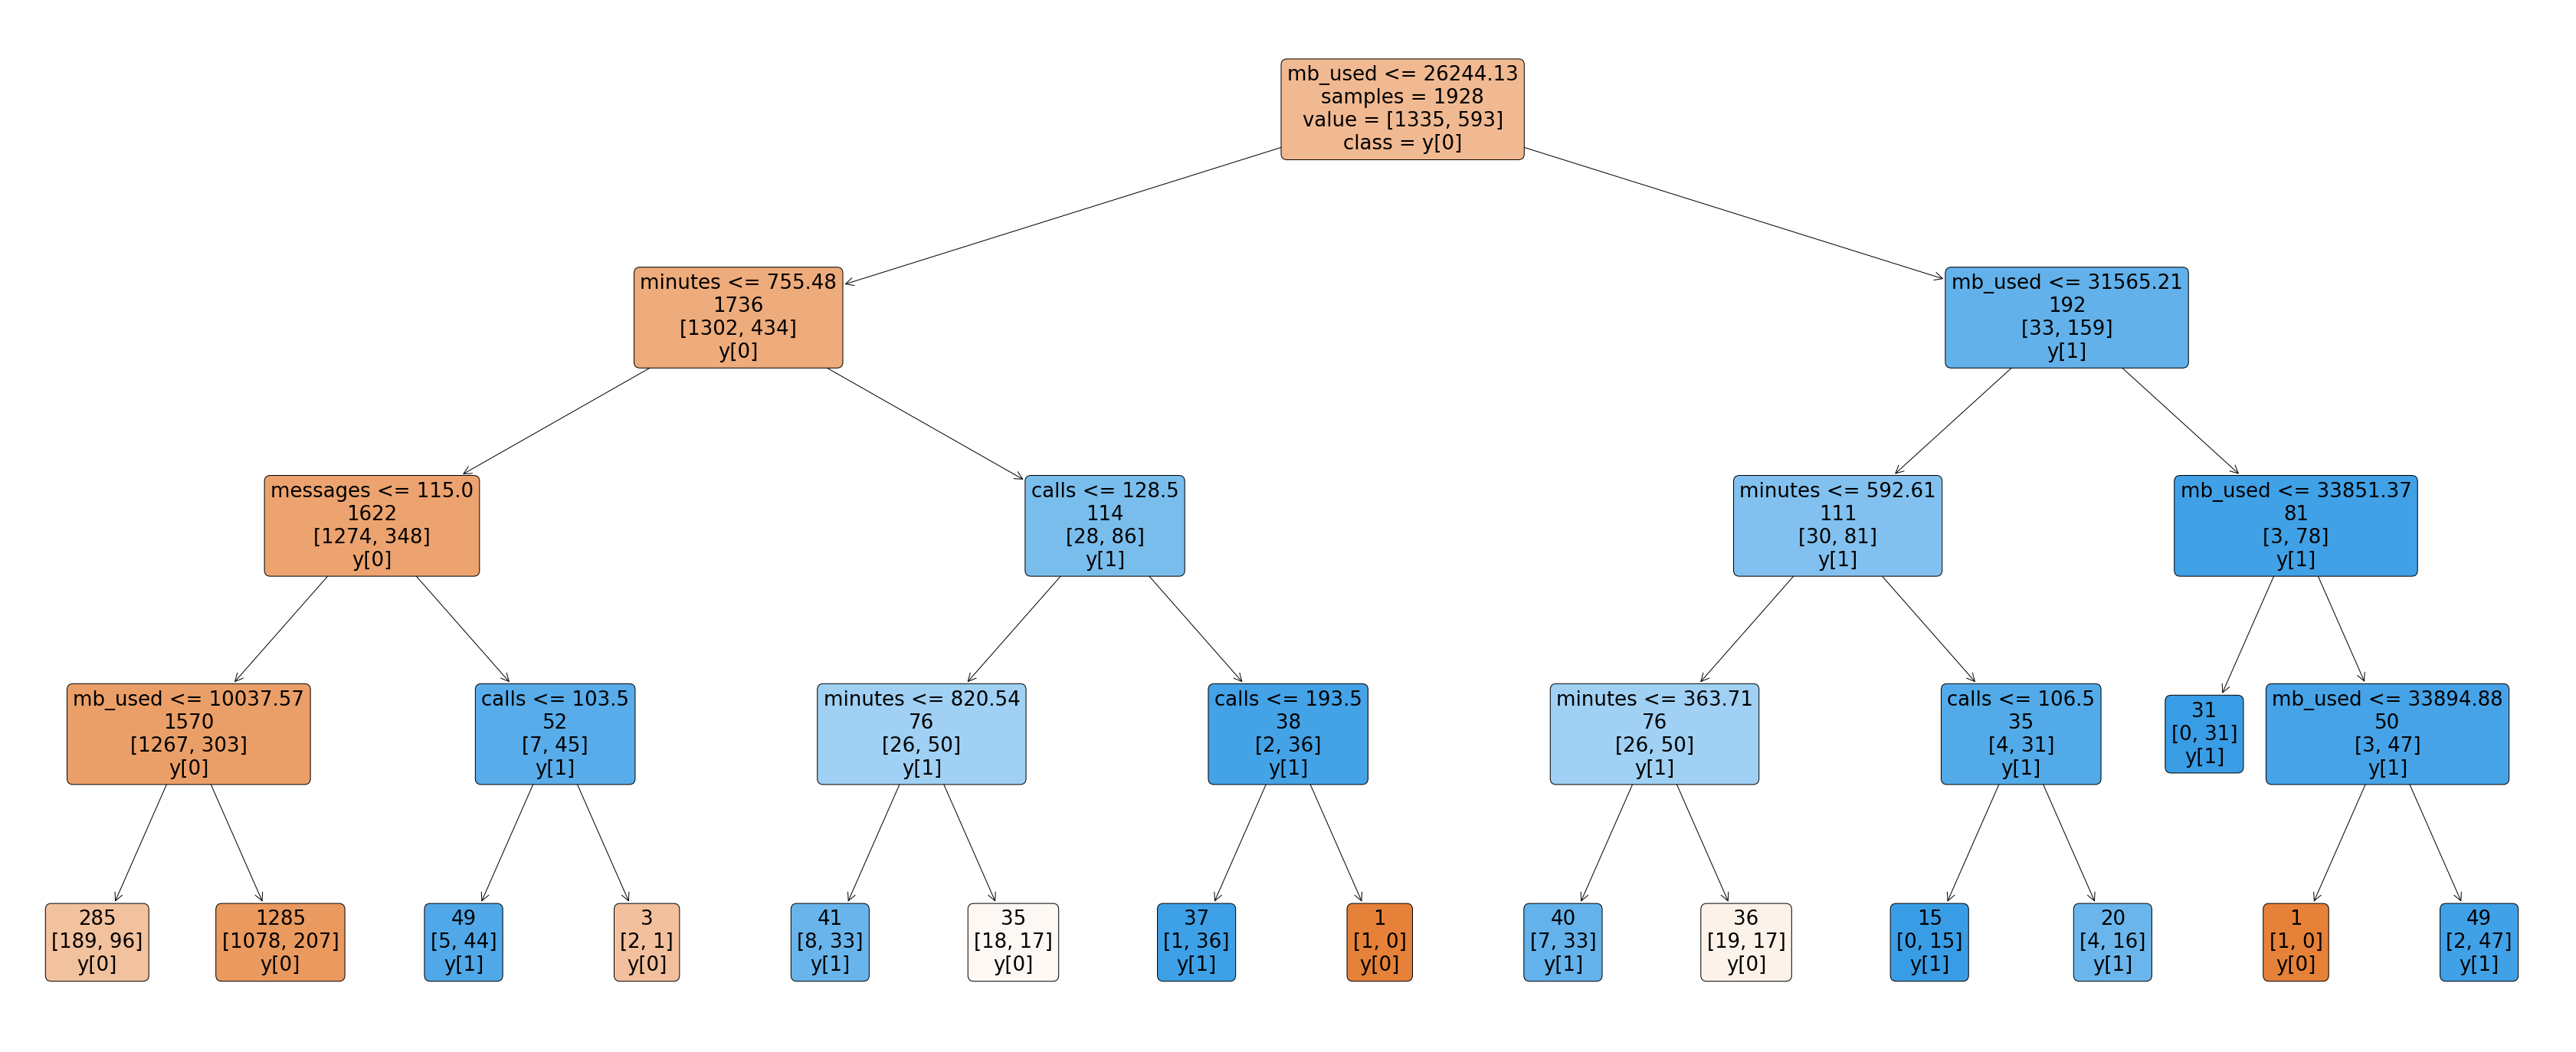

In [15]:
#Построим график с "глубиной деревьев" = 4
model_dt = DecisionTreeClassifier(random_state=12345, max_depth=4)
model_dt.fit(features_train, target_train)
predictions = model_dt.predict(features_valid)
result = accuracy_score(target_valid, predictions)

plt.figure(figsize=(60,25))
fig = plot_tree(model_dt, 
                feature_names=features_train.columns, 
                precision = 2,
                filled = True, 
                rounded = True,
                class_names = True,
                fontsize = 26, 
                label = 'root', 
                impurity=False)

### Случайный лес

In [16]:
%%time
#Проверим значение accuracy при увеличении числа деревьев 1 до 100

best_model = None
best_result = 0
best_est = 0
best_depth = 0
for depth in range(1,11):
    for est in range(1, 101, 5):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        result = accuracy_score(target_valid, predictions)
        if result > best_result:
            best_model = model
            best_result = result
            best_est = est
            best_depth = depth
            
print('Наилучшее значение показала модель с количеством деревьев =', best_est, 'с "глубиной деревьев" =', best_depth, ', accuracy =', best_result)

Наилучшее значение показала модель с количеством деревьев = 26 с "глубиной деревьев" = 7 , accuracy = 0.807153965785381
CPU times: user 23.7 s, sys: 143 ms, total: 23.9 s
Wall time: 23.9 s


### Логистическая регрессия

In [17]:
#Рассчитаем значение accuracy модели логистической регрессии на валидационной выборке

model_lr = LogisticRegression(random_state=12345, solver='lbfgs')
model_lr.fit(features_train, target_train)
predictions = model_lr.predict(features_valid)
result = accuracy_score(target_valid, predictions)

print('Данная модель демонстрирует значение accuracy =', result)

Данная модель демонстрирует значение accuracy = 0.7107309486780715


In [18]:
#Поменяем гиперпараметры

model_lr = LogisticRegression(random_state=12345, solver='liblinear', penalty='l2')
model_lr.fit(features_train, target_train)
predictions = model_lr.predict(features_valid)
result = accuracy_score(target_valid, predictions)

print('Данная модель демонстрирует значение accuracy =', result)

Данная модель демонстрирует значение accuracy = 0.7091757387247278


In [19]:
#Поменяем гиперпараметры

model_lr = LogisticRegression(random_state=12345, solver='liblinear', penalty='l1')
model_lr.fit(features_train, target_train)
predictions = model_lr.predict(features_valid)
result = accuracy_score(target_valid, predictions)

print('Данная модель демонстрирует значение accuracy =', result)

Данная модель демонстрирует значение accuracy = 0.7573872472783826


У логистическая регрессия наименьший показатель accuracy 

### Вывод

**Модель с лучшим показателем accuracy:**
    
    - Тип модели RandomForestClassifier (Случайный лес)
    - Значение n_estimators = 26
    - Значение depth = 7
    - Значение accuracy = 0.807153965785381


## Проверьте модель на тестовой выборке

In [20]:
#обучим модель на тренировочной + валидационной выборке

features_final = pd.concat([features_train, features_valid])
target_final = pd.concat([target_train, target_valid])

print('Размер обучающей выборки:', target_final.shape, '-', round(len(features_final) / len(df)*100), '%')
print('Размер обучающей выборки:', target_final.shape, '-', round(len(features_final) / len(df)*100), '%')

Размер обучающей выборки: (2571,) - 80 %
Размер обучающей выборки: (2571,) - 80 %


In [21]:
model_final = RandomForestClassifier(random_state=12345, n_estimators=26, max_depth=7)
model_final.fit(features_final, target_final)
predictions = model_final.predict(features_test)
result = accuracy_score(target_test, predictions)

print('accuracy =', result)

accuracy = 0.8055987558320373


- Значение accuracy в валидационной выборке = 0.807153965785381
- Значение accuracy в тестовой выборке = 0.8055987558320373

## (бонус) Проверьте модели на адекватность

In [22]:
#Для проверки модели на адекватность будем использовать классификатор DummyClassifier из библиотеки Skelarn
#DummyClassifier - классификатор, который полезен в качестве простой основы для сравнения с другими (реальными)классификаторами
#Если его способность предсказать результат будет лучше чем у модели случайного леса, то наша модель работает плохо

strategies = ['stratified', 'most_frequent', 'uniform'] 

for strategy in strategies:
    model = DummyClassifier(strategy = strategy, random_state = 12345)
    model.fit(features_train, target_train) 
    predictions = model.predict(features_test)
    result = accuracy_score(target_test, predictions)
    print(strategy, '- accuracy =', result)     

stratified - accuracy = 0.536547433903577
most_frequent - accuracy = 0.6842923794712286
uniform - accuracy = 0.4821150855365474


**Вывод:**
    
Модель случайного леса с гиперпараметрами n_estimators = 26 и max_depth = 7 работает лучше, чем случайное прогнозирование классификатора DummyClassifier()

**Модель с лучшим показателем accuracy:**
    
    - Тип модели RandomForestClassifier (Случайный лес)
    - Значение n_estimators = 26
    - Значение depth = 7
    - Значение accuracy в тестовой выборке = 0.8055987558320373

Модель работает достаточно хорошо — она способна правильно предсказать около 80% ответов. Можем считать, что цель проекта достигнута.